In [105]:
import pickle
import os

os.environ['CUDA_VISIBLE_DEVICES'] = f''

import numpy as np

import jax
from jax.config import config
config.update("jax_enable_x64", True)  # crucial for Gaussian processes
import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx

## Idea
Collect all results by loading each pickle file within an experiment folder.
Then combine all particles in various ways: 
- mean and variance over posteriors and predictive
- mean and variance over u and z particles accross runs

In [107]:
def get_files_paths(file_name, path):
    """
    Finds all `file_name` within `path` including subfolders
        and returns a list with complete file path per found file.
    """
    found_paths = []
    for root, _, files in os.walk(path):
        filtered_files = list(
            filter(lambda fname: file_name == fname, files))
        if len(filtered_files) == 1:
            found_paths.append(root + '/' + filtered_files[0])
    
    return found_paths

def load_pickles(paths):
    """
    Loads a bunch pickles located at `paths`,
        unpickles and returns their content in a list ready for serving.
    """
    vars = []
    for path in paths:
        with open(path, 'rb') as file: 
            vars.append(pickle.load(file))
    return vars

path = './results_sparse_gp_test/2023-12-09_17-56_fullTest_40-inducing_100mcmc/'

data = dict(
    x = None,
    y = None,
    ground_truth = None,
    initial_particles = None,
    particles = None,
    marginal_likelihood=None)

for k in data:
    data[k] = load_pickles(get_files_paths(f'{k}.pickle', path))

for ps in data['particles']:
    print(ps.particles.keys())


dict_keys(['Z', 'f', 'inducing_inputs_Z', 'kernel', 'likelihood', 'u'])
dict_keys(['Z', 'f', 'inducing_inputs_Z', 'kernel', 'likelihood', 'u'])
dict_keys(['Z', 'f', 'inducing_inputs_Z', 'kernel', 'likelihood', 'u'])


(3, 1000, 100)


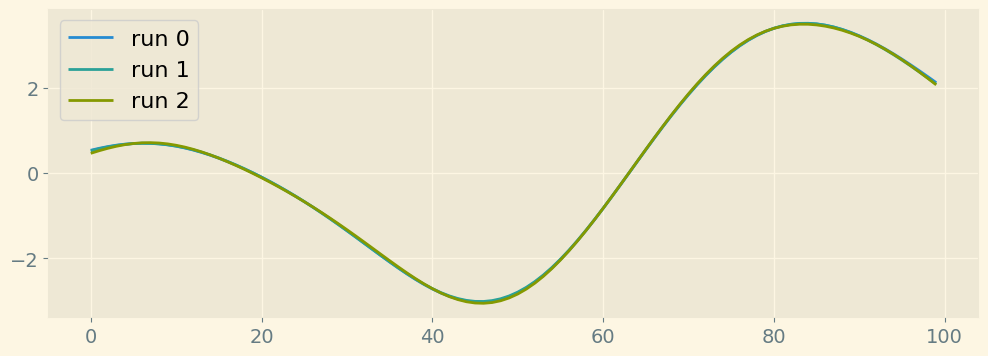

In [121]:
# create particle means

data_processed = dict(
    f = None,
    u = None,
    Z = None)

# Idea: combine everything in numpy arrays do compute averages etc.
# e.g. num_runs, num_particles, num_variables per variable

num_runs = len(data['particles'])
for k in data_processed:
    num_particles, num_variables = data['particles'][0].particles[k].shape
    data_processed[k] = np.zeros((num_runs, num_particles, num_variables))
    for i in range(num_runs):
        data_processed[k][i] = data['particles'][i].particles[k]

print(data_processed['f'].shape)  

import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
for i in range(num_runs):
    f_mean_per_run = np.mean(data_processed['f'], axis=1)
    plt.plot(f_mean_per_run[i, :], label=f'run {i}')
plt.legend()

In [74]:
from sprase_gp_test import plot_smc

plot_smc(
    data['x'][0],
    data['y'][0],
    data['particles'][0].particles,
    data['ground_truth'][0],
    f'average_{len(data["x"])}_seeds',
    folder=path)